In [6]:
import os
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
movies_df = pd.read_csv("/Users/georgenteves/rec_sys_proj/data/serendipity-sac2018/movies.csv",sep=',')

In [8]:
movies_df = movies_df.drop(['releaseDate', 'imdbId', 'tmdbId', 'Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11'], axis = 1) 

In [9]:
answers_df = pd.read_csv("/Users/georgenteves/rec_sys_proj/data/serendipity-sac2018/answers.csv",sep=',')

In [10]:
answers_df = answers_df.drop(['rating', 'predictedRating', 's_ser_rel', 'q','s_ser_find','s_ser_imp','s_ser_rec', 'm_ser_rel', 'm_ser_find', 'm_ser_imp' , 'm_ser_rec'], axis = 1) 

In [11]:
movies_rated_by_user = {}
answers_df_timestamp_ascending = answers_df.sort_values('timestamp')
answers_df_timestamp_ascending = answers_df_timestamp_ascending.reset_index(drop=True)

for answer in range(0, len(answers_df_timestamp_ascending)):
    if int(answers_df_timestamp_ascending['userId'][answer]) in movies_rated_by_user:
        movies_rated_by_user[int(answers_df_timestamp_ascending['userId'][answer])].append(int(answers_df_timestamp_ascending['movieId'][answer]))
    else:
        movies_rated_by_user[int(answers_df_timestamp_ascending['userId'][answer])] = []
        movies_rated_by_user[int(answers_df_timestamp_ascending['userId'][answer])].append(answers_df_timestamp_ascending['movieId'][answer])        

# SImilarity movies per user

In [12]:
def jaccard_similarity_with_previous_rated_movies(user_movies_list, current_movie):
    
    total_similarity_sum = 0
    total_movies_number = 0
    
    for movie in user_movies_list:
        number_of_criteria = 0
        current_similarity_sum = 0
        
        if (movies_df.index[movies_df['movieId'] == current_movie][0] - 1) >= 0:
            list1 = movies_df['directedBy'][movies_df.index[movies_df['movieId'] == movie][0] - 1].split(',')
            list2 = movies_df['directedBy'][movies_df.index[movies_df['movieId'] == current_movie][0] - 1].split(',')
            intersection = len(list(set(list1).intersection(list2)))
            union = (len(list1) + len(list2)) - intersection
            current_similarity_sum += float(intersection) / union
            number_of_criteria += 1

            list1 = movies_df['starring'][movies_df.index[movies_df['movieId'] == movie][0] - 1].split(',')
            list2 = movies_df['starring'][movies_df.index[movies_df['movieId'] == current_movie][0] - 1].split(',')
            intersection = len(list(set(list1).intersection(list2)))
            union = (len(list1) + len(list2)) - intersection
            current_similarity_sum += float(intersection) / union
            number_of_criteria += 1

            list1 = movies_df['genres'][movies_df.index[movies_df['movieId'] == movie][0] - 1].split(',')
            list2 = movies_df['genres'][movies_df.index[movies_df['movieId'] == current_movie][0] - 1].split(',')
            intersection = len(list(set(list1).intersection(list2)))
            union = (len(list1) + len(list2)) - intersection
            current_similarity_sum += float(intersection) / union
            number_of_criteria += 1

            current_similarity = current_similarity_sum / number_of_criteria
            total_similarity_sum += current_similarity
            total_movies_number += 1
    
    if total_movies_number > 0:
        answer = total_similarity_sum / total_movies_number
    else:
        answer = 0
    
    return answer

In [13]:
def similarity_with_previous_rated_movies_by_user(userId, current_movie):
    similarity = 0
    if userId in movies_rated_by_user:
        if current_movie not in movies_rated_by_user[userId]:
            similarity = jaccard_similarity_with_previous_rated_movies(movies_rated_by_user[userId], current_movie)
        else:
            previous_movies_rated_by_user = []
            current_movie_index = movies_rated_by_user[userId].index(current_movie)
            for movie_index in range(0, len(movies_rated_by_user[userId])):
                if movie_index < current_movie_index:
                    previous_movies_rated_by_user.append(movies_rated_by_user[userId][movie_index])
                else:
                    break
            if len(previous_movies_rated_by_user) > 0:
                similarity = jaccard_similarity_with_previous_rated_movies(previous_movies_rated_by_user, current_movie)  
                
    return similarity

### Popularity in ml-latest-small

In [14]:
movies_ratings = pd.read_csv("/Users/georgenteves/rec_sys_proj/data/ml-latest-small/ratings.csv",sep=',')

In [15]:
movies_all = pd.read_csv("/Users/georgenteves/rec_sys_proj/data/ml-latest-small/movies.csv",sep=',')

In [16]:
rated_movies_popularity = {}

for movie in range(0, len(movies_ratings)):
    if int(movies_ratings['movieId'][movie]) not in rated_movies_popularity:
        times_rated = len(movies_ratings.loc[movies_ratings['movieId'] == int(movies_ratings['movieId'][movie])])
        rated_movies_popularity[int(movies_ratings['movieId'][movie])] = -np.log10(times_rated / movies_ratings['userId'].nunique())

# Serendipity index

In [17]:
questions = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8']
movies_serendipity_sum = {}
movies_serendipity_users = {}
movies_serendipity = {}

for answer in range(0, len(answers_df_timestamp_ascending)):
    number_of_questions = 0
    current_user_serendipity_sum = 0
    
    for question in questions:
        if (np.isnan(answers_df_timestamp_ascending[question][answer]) == False):
            number_of_questions += 1
            current_user_serendipity_sum += answers_df_timestamp_ascending[question][answer]/5
    
    if number_of_questions != 0:
        current_user_serendipity = current_user_serendipity_sum / number_of_questions
    
    if int(answers_df_timestamp_ascending['movieId'][answer]) not in movies_serendipity_sum:
        movies_serendipity_sum[int(answers_df_timestamp_ascending['movieId'][answer])] = current_user_serendipity
    else:
        movies_serendipity_sum[int(answers_df_timestamp_ascending['movieId'][answer])] += current_user_serendipity
        
    if int(answers_df_timestamp_ascending['movieId'][answer]) not in movies_serendipity_users:
        movies_serendipity_users[int(answers_df_timestamp_ascending['movieId'][answer])] = 1
    else:
        movies_serendipity_users[int(answers_df_timestamp_ascending['movieId'][answer])] += 1

for movie in movies_serendipity_users:
    movies_serendipity[movie] = movies_serendipity_sum[movie] / movies_serendipity_users[movie]


# Categories

In [18]:
import random

number_of_categories = 5
movie_ids = movies_df["movieId"].unique()
random.shuffle(movie_ids)

In [19]:
categories = np.random.randint(low = 0,high = number_of_categories+1, size=len(movie_ids))

In [20]:
movies_with_categories = pd.DataFrame({'Movie Id': movie_ids[:], 'Category': categories[:],'Values':np.ones(len(movie_ids))}) 

In [21]:
categorized_movies = movies_with_categories.pivot(
    index='Category',
    columns='Movie Id',
    values='Values'
).fillna(0).astype(int)

In [22]:
cat_dict = {}
for cat_id in movies_with_categories['Category'].unique():
    cat_dict[cat_id] = movies_with_categories.loc[movies_with_categories['Category']==cat_id]['Movie Id'].tolist()

In [23]:
movies_df['directedBy'].fillna('', inplace=True)
movies_df['starring'].fillna('', inplace=True)
movies_df['genres'].fillna('', inplace=True)

In [24]:
model_df = pd.DataFrame(
    [int(row['userId']), int(row['movieId']), similarity_with_previous_rated_movies_by_user(int(row['userId']), int(row['movieId'])), rated_movies_popularity[int(row['movieId'])], movies_serendipity[int(row['movieId'])]] for index, row in answers_df_timestamp_ascending.iterrows() if int(row['movieId']) in rated_movies_popularity)

In [25]:
model_df.columns = ['userId', 'movieId', 'similarity_previous_rated_by_user', 'popularity', 'movie_serendipity']

In [26]:
model_df.loc[(model_df.movie_serendipity >= 0.5),'movie_serendipity']= int(1)
model_df.loc[(model_df.movie_serendipity < 0.5),'movie_serendipity']= int(0)

In [27]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(model_df, test_size = 0.2, random_state = 28)
print ('The size of train set and test set is {0} and {1} respectively.'.format(len(train_set),len(test_set)))

The size of train set and test set is 1152 and 288 respectively.


In [28]:
train_X = []
train_Y = []

for index, values in train_set.iterrows():
    train_X.append([values['similarity_previous_rated_by_user'], values['popularity']])
    train_Y.append(values['movie_serendipity'])

In [29]:
test_X = []
test_Y = []

for index, values in test_set.iterrows():
    test_X.append([values['similarity_previous_rated_by_user'], values['popularity']])
    test_Y.append(values['movie_serendipity'])

# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_X, train_Y)

In [31]:
clf.score(test_X,test_Y)

0.7465277777777778

In [32]:
from sklearn.metrics import mean_squared_error
y_pred = clf.predict(test_X)

In [33]:
mean_squared_error(test_Y, y_pred)

0.2534722222222222

# Non-Linear

In [34]:
from sklearn.tree import DecisionTreeClassifier

regressor = DecisionTreeClassifier(random_state = 0)  
regressor.fit(train_X, train_Y) 
regressor.score(test_X, test_Y) 

0.6701388888888888

In [35]:
y_pred = regressor.predict(test_X)
mean_squared_error(test_Y, y_pred)

0.3298611111111111

# Solver

In [36]:
#minified movies categories with 10 movies per category
min_cat_dict = {}

for cat_id in cat_dict:
    min_cat_dict[cat_id] = []
    current_categories_movies = pd.DataFrame(
    [int(cat_dict[cat_id][movie_index]), rated_movies_popularity[cat_dict[cat_id][movie_index]]] for movie_index in range(0, len(cat_dict[cat_id])) if cat_dict[cat_id][movie_index] in rated_movies_popularity)
    current_categories_movies.columns = ['movieId', 'popularity']
    current_categories_movies_ascending = current_categories_movies.sort_values(by='popularity')
    current_categories_movies_ascending = current_categories_movies_ascending.reset_index()
    for movie in current_categories_movies_ascending[0:10].iterrows():
        min_cat_dict[cat_id].append(int(movie[1]['movieId']))

In [37]:
all_movies_min = []

for cat_id in min_cat_dict:
    for movie_index in range(0, len(min_cat_dict[cat_id])):
        all_movies_min.append(min_cat_dict[cat_id][movie_index])

In [38]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [39]:
params = []
the_users = selection_sort(answers_df['userId'].unique())[0:10] #[0:int(len(all_movies_min)/2)]
the_users = np.array(the_users).tolist()

for index in range(0, len(all_movies_min)):
    if index < len(the_users):
        params.append({
            "movieId": all_movies_min[index],
            "userId": the_users[index],
            "recommendation": 0
        })
    else:
        params.append({
            "movieId": all_movies_min[index],
            "userId": 0,
            "recommendation": 0
        })
    
x_df = pd.DataFrame(params)

In [40]:
# pivot ratings into movie features
x_pivot = x_df.pivot(
    index='movieId',
    columns='userId',
    values='recommendation'
).fillna(0)

In [41]:
from collections import defaultdict
x_dict = {}
for ind,row in x_pivot.iterrows():
    dd = row.to_dict()
    for us in dd:
        if us > 0:
            x_dict[(us,ind)] = dd[us]

In [42]:
x_dict_keys = []
for k in x_dict:
    x_dict_keys.append(k)

In [43]:
predicted = {}
similarities_user_movies = {}
for u in the_users:
    for c in min_cat_dict:
        for m in range(0, len(min_cat_dict[c])):
            similarities_user_movies[(u,min_cat_dict[c][m])] = similarity_with_previous_rated_movies_by_user(u, min_cat_dict[c][m])
            predicted[(similarities_user_movies[(u,min_cat_dict[c][m])], rated_movies_popularity[min_cat_dict[c][m]])] = clf.predict([[similarities_user_movies[(u,min_cat_dict[c][m])], rated_movies_popularity[min_cat_dict[c][m]]]])  

In [44]:
for k1, k2 in predicted:
    predicted[(k1,k2)] = predicted[(k1,k2)][0]

In [45]:
import math
from pyomo.environ import *
import pyomo.environ as pyomo
from pyomo.solvers import plugins
import gurobi as GUROBI

In [59]:
def serendipity_recommendation_solver(theta, recommendations_num, domainType = 0, with_disimilarity = 0):
    Recs = x_dict_keys
    model = pyomo.ConcreteModel()

    model.Cats = Set(initialize=min_cat_dict.keys())
    model.Users = Set(initialize=the_users)
    model.Movies = Set(initialize=all_movies_min)

    if domainType == 0:
        model.x = pyomo.Var(Recs, bounds=(0,1), domain=Boolean)
    else:
        model.x = pyomo.Var(Recs, bounds=(0,1), domain=PositiveReals)
    
    
    def maximun_recommendation_constraint(model, u):
        return np.sum(np.sum(model.x[u, min_cat_dict[c][i]] for i in range(0, len(min_cat_dict[c]))) for c in model.Cats) == recommendations_num
    
    model.MaximumRecommendationConstraint = Constraint(model.Users, rule=maximun_recommendation_constraint)
    
    if with_disimilarity == 0:
        def minimum_average_serendipity(model, c):
            return (1/len(min_cat_dict[c]))*np.sum(np.sum(predicted[(similarity_with_previous_rated_movies_by_user(u, min_cat_dict[c][i]), rated_movies_popularity[min_cat_dict[c][i]])]*model.x[u, min_cat_dict[c][i]] for i in range(0, len(min_cat_dict[c]))) for u in model.Users) >= theta

        model.Sc = pyomo.Constraint(model.Cats, rule=minimum_average_serendipity)

        def maximizer_obj(model):
            return (1/len(the_users))*np.sum(np.sum(predicted[(similarity_with_previous_rated_movies_by_user(u, all_movies_min[i]), rated_movies_popularity[all_movies_min[i]])]*model.x[u, all_movies_min[i]] for i in range(0, len(all_movies_min))) for u in model.Users)

    else:
        def minimum_average_serendipity(model, c):
            return (1/len(min_cat_dict[c]))*np.sum(np.sum(predicted[(similarity_with_previous_rated_movies_by_user(u, min_cat_dict[c][i]), rated_movies_popularity[min_cat_dict[c][i]])]*model.x[u, min_cat_dict[c][i]] for i in range(0, len(min_cat_dict[c])))+np.sum(d[(min_cat_dict[c][i],all_movies_min[j])]*model.x[u,min_cat_dict[c][i]]*model.x[u,all_movies_min[j]] for j in range(0, len(all_movies_min)) for i in range(0, len(min_cat_dict[c])) if all_movies_min[j] != min_cat_dict[c][i]) for u in model.Users) >= theta

        model.Sc = pyomo.Constraint(model.Cats, rule=minimum_average_serendipity)

        def maximizer_obj(model):
            return (1/len(the_users))*np.sum(np.sum(predicted[(similarity_with_previous_rated_movies_by_user(u, all_movies_min[i]), rated_movies_popularity[all_movies_min[i]])]*model.x[u, all_movies_min[i]] for i in range(0, len(all_movies_min)))+np.sum(d[(all_movies_min[i],all_movies_min[j])]*model.x[u,all_movies_min[i]]*model.x[u,all_movies_min[j]] for j in range(0, len(all_movies_min)) for i in range(0, len(all_movies_min)) if all_movies_min[j] != all_movies_min[i]) for u in model.Users)
        
    model.Obj = Objective(rule=maximizer_obj, sense=maximize)

    
    if with_disimilarity != 0 and domainType != 0:
        solver = SolverFactory('ipopt')
    else:    
        solver = SolverFactory('gurobi', solver_io="python")
        if with_disimilarity != 0:
            solver.options['timelimit'] = 10
    results = solver.solve(model,tee=False)
    
    serendipity_recommendation_solver_solutions = {}

    for rec in Recs:
        if not model.x[rec]() is None and model.x[rec]() > 0:
            serendipity_recommendation_solver_solutions[rec] = model.x[rec]()

    if len(serendipity_recommendation_solver_solutions) > 0:
        pairs_users = []
        pairs_movies = []
        pairs_recommendation = []

        for pair in serendipity_recommendation_solver_solutions:
            u = pair[0]
            i = pair[1]
            pairs_users.append(u)
            pairs_movies.append(i)
            recommendation = serendipity_recommendation_solver_solutions[pair]
            pairs_recommendation.append(recommendation)

        all_recommendations_ui = pd.DataFrame(
            {'userId': pairs_users,
             'movieId': pairs_movies,
             'recommendation': pairs_recommendation
            }).sort_values(by=['userId','recommendation'], ascending=False)

        all_recommendations_ui_matrix = all_recommendations_ui.pivot(
                index="userId", columns="movieId", values="recommendation"
            ).fillna(0)
        
        final_pairs_users = []
        final_pairs_movies = []
        final_pairs_recommendation = []
        recommendations_per_user = {}

        for u in the_users:
            for index, row in all_recommendations_ui.loc[all_recommendations_ui['userId'] == u][0:recommendations_num].iterrows():
                final_pairs_users.append(int(row['userId']))
                final_pairs_movies.append(int(row['movieId']))
                final_pairs_recommendation.append(row['recommendation'])
                
                if int(row['userId']) not in recommendations_per_user:
                    recommendations_per_user[int(row['userId'])] = [int(row['movieId'])]
                else:
                    recommendations_per_user[int(row['userId'])].append(int(row['movieId']))
        
        final_recommendations_ui = pd.DataFrame(
            {'userId': final_pairs_users,
             'movieId': final_pairs_movies,
             'recommendation': final_pairs_recommendation
            }).sort_values(by=['userId', 'recommendation'], ascending=False)
        
        score = model.Obj()
        
        return score, all_recommendations_ui_matrix, final_recommendations_ui
    else:
        score = 0
        return score, [], []
    

# Without disimilaritiy (d = 0)

Boolean

In [46]:
#function parameters -> (theta, recommendations_num (e.g. 2, 3), Boolean/Continuous (0/1), with/without disimilarity (1/0))
score, matrix, recommendations_pairs = serendipity_recommendation_solver(0.3, 2, 0)
print('Number of categories:',len(min_cat_dict),'| Number of movies:',len(all_movies_min),'| Number of users:',len(the_users))
print()    
print('Maximization score:',score)
print()
print('All model recommendations:')
print(matrix)
print()
print('The best L recommendations per user:')
print(recommendations_pairs)

Number of categories: 6 | Number of movies: 60 | Number of users: 10

Maximization score: 2.0

All model recommendations:
movieId  32    153   293   316   367   457   588   590   595   858   1193  \
userId                                                                      
100200    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
100269    0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
100521    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
100972    0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
100998    1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
101049    0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
101170    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   
101263    0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
101318    0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
101579    0.0   0.0   0.0   0.0

Continuous

In [49]:
#function parameters -> (theta, recommendations_num (e.g. 2, 3), Boolean/Continuous (0/1), with/without disimilarity (1/0))
score, matrix, recommendations_pairs = serendipity_recommendation_solver(0.33, 2, 1)
print('Number of categories:',len(min_cat_dict),'| Number of movies:',len(all_movies_min),'| Number of users:',len(the_users))
print()    
print('Maximization score:',score)
print()
print('All model recommendations:')
print(matrix)
print()
print('The best L recommendations per user:')
print(recommendations_pairs)

Number of categories: 6 | Number of movies: 60 | Number of users: 10

Maximization score: 2.0

All model recommendations:
movieId  10    32    293   588   590   592   595   608   780   858   ...  \
userId                                                               ...   
100200    0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  ...   
100269    0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
100521    0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   
100972    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0  ...   
100998    1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
101049    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
101170    0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
101263    0.0   0.0   0.0   0.0   0.0   0.8   0.0   0.0   0.0   0.0  ...   
101318    0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
101579    0.0   0.0   0.0   0.0   1.0   0.

# With dimisimilarity (d!=0)

In [47]:
def movies_disimilarity(m1, m2):
    number_of_criteria = 0
    similarity_sum = 0
    disimilarity = 1
    
    list1 = movies_df['directedBy'][movies_df.index[movies_df['movieId'] == m1][0]].split(',')
    list2 = movies_df['directedBy'][movies_df.index[movies_df['movieId'] == m2][0]].split(',')
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    similarity_sum += float(intersection) / union
    number_of_criteria += 1

    list1 = movies_df['starring'][movies_df.index[movies_df['movieId'] == m1][0]].split(',')
    list2 = movies_df['starring'][movies_df.index[movies_df['movieId'] == m2][0]].split(',')
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    similarity_sum += float(intersection) / union
    number_of_criteria += 1

    list1 = movies_df['genres'][movies_df.index[movies_df['movieId'] == m1][0]].split(',')
    list2 = movies_df['genres'][movies_df.index[movies_df['movieId'] == m2][0]].split(',')
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    similarity_sum += float(intersection) / union
    number_of_criteria += 1

    if number_of_criteria > 0:
        similarity = similarity_sum / number_of_criteria
        disimilarity = disimilarity - similarity
    
    return disimilarity    

In [48]:
d = {}
for m1 in range(0, len(all_movies_min)):
    for m2 in range(0, len(all_movies_min)):
        if all_movies_min[m1] != all_movies_min[m2]:
            d[(all_movies_min[m1],all_movies_min[m2])] = movies_disimilarity(all_movies_min[m1], all_movies_min[m2])

Boolean

In [52]:
#function parameters -> (theta, recommendations_num (e.g. 2, 3), Boolean/Continuous (0/1), with/without disimilarity (1/0))
score, matrix, recommendations_pairs = serendipity_recommendation_solver(0.4, 3, 0, 1)
print('Number of categories:',len(min_cat_dict),'| Number of movies:',len(all_movies_min),'| Number of users:',len(the_users))
print()    
print('Maximization score:',score)
print()
print('All model recommendations:')
print(matrix)
print()
print('The best L recommendations per user:')
print(recommendations_pairs)

    containing a solution
Number of categories: 6 | Number of movies: 60 | Number of users: 10

Maximization score: 9.0

All model recommendations:
movieId  10    47    457   595   597   1214  1265  2762
userId                                                 
100200    0.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0
100269    0.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0
100521    0.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0
100972    0.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0
100998    1.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0
101049    0.0   1.0   0.0   0.0   1.0   1.0   0.0   0.0
101170    0.0   0.0   1.0   1.0   0.0   0.0   0.0   1.0
101263    0.0   0.0   1.0   1.0   0.0   0.0   0.0   1.0
101318    0.0   0.0   1.0   1.0   0.0   0.0   0.0   1.0
101579    0.0   0.0   1.0   0.0   0.0   0.0   1.0   1.0

The best L recommendations per user:
    userId  movieId  recommendation
27  101579      457             1.0
28  101579     1265             1.0
29  101579     2762             1.

Continuous

In [53]:
#function parameters -> (theta, recommendations_num (e.g. 2, 3), Boolean/Continuous (0/1), with/without disimilarity (1/0))
score, matrix, recommendations_pairs = serendipity_recommendation_solver(0.4, 2, 1, 1)
print('Number of categories:',len(min_cat_dict),'| Number of movies:',len(all_movies_min),'| Number of users:',len(the_users))
print()    
print('Maximization score:',score)
print()
print('All model recommendations:')
print(matrix)
print()
print('The best L recommendations per user:')
print(recommendations_pairs)

Number of categories: 6 | Number of movies: 60 | Number of users: 10

Maximization score: 5.7026049222484945

All model recommendations:
movieId         1         10        32            47            50     \
userId                                                                  
100200   0.000000e+00  0.017987  0.052549  1.035769e-01  4.856085e-02   
100269   0.000000e+00  0.029677  0.082491  1.271015e-09  2.115749e-10   
100521   2.210818e-11  0.025468  0.083667  1.294348e-09  3.076919e-10   
100972   0.000000e+00  0.018085  0.051884  1.031181e-01  4.879277e-02   
100998   4.331618e-11  0.034835  0.097761  1.771348e-09  5.394006e-10   
101049   0.000000e+00  0.018085  0.051884  1.031181e-01  4.879277e-02   
101170   7.621493e-12  0.026546  0.083229  1.281337e-09  2.452699e-10   
101263   3.760401e-12  0.025618  0.083750  1.284018e-09  2.492611e-10   
101318   8.691885e-11  0.026844  0.082926  1.336827e-09  3.408280e-10   
101579   1.284454e-11  0.025798  0.083692  1.287629e-09  3.0

# Plots

In [49]:
import matplotlib.pyplot as plt

In [50]:
theta_values = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
recommendations_values = [2, 3]

Without disimilarity (d != 0)

Boolean

In [66]:
theta_results = []
recommendations_results = []
serendipity_results_boolean = []
max_score_boolean = []

In [67]:
for theta in theta_values:
    for recommendations in recommendations_values:
        theta_results.append(theta)
        recommendations_results.append(recommendations)
        score, matrix, recommendations_pairs = serendipity_recommendation_solver(theta, recommendations, 0)
        max_score_boolean.append(score)
        total_serendipity = 0
        if len(recommendations_pairs) > 0:
            for u in recommendations_pairs['userId'].unique():
                for m in recommendations_pairs['movieId'].unique():
                    total_serendipity += predicted[(similarities_user_movies[(u,m)], rated_movies_popularity[m])]
        serendipity_results_boolean.append(total_serendipity)

    model=unknown;
        message from solver=<undefined>
    model=unknown;
        message from solver=<undefined>
    model=unknown;
        message from solver=<undefined>
    model=unknown;
        message from solver=<undefined>


In [68]:
serendipity_results_boolean

[166.0, 198.0, 166.0, 198.0, 0, 248.0, 0, 248.0, 0, 233.0, 0, 233.0]

In [69]:
max_score_boolean

[2.0, 3.0, 2.0, 3.0, 0, 3.0, 0, 3.0, 0, 3.0, 0, 3.0]

In [101]:
serendipity_results_boolean_df = pd.DataFrame(
            {'theta': theta_results,
             'serendipity_indexes': serendipity_results_boolean,
             'L': recommendations_results,
             'max_score': max_score_boolean
            })

In [102]:
serendipity_results_boolean_df

,theta,serendipity_indexes,L,max_score
0,0.25,166.0,2,2.0
1,0.25,198.0,3,3.0
2,0.30,166.0,2,2.0
3,0.30,198.0,3,3.0
4,0.35,0.0,2,0.0
5,0.35,248.0,3,3.0
6,0.40,0.0,2,0.0
7,0.40,248.0,3,3.0
8,0.45,0.0,2,0.0
9,0.45,233.0,3,3.0


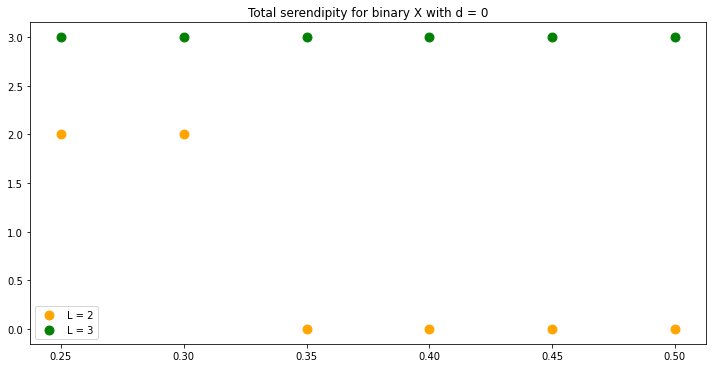

In [72]:
df1 = serendipity_results_boolean_df.loc[serendipity_results_boolean_df['L'] == 2]
df2 = serendipity_results_boolean_df.loc[serendipity_results_boolean_df['L'] == 3]

plt.figure(figsize=(10, 5))
plt.scatter(df1.theta, df1.max_score, c='orange', s=80, label='L = 2')
plt.scatter(df1.theta, df2.max_score, c='green', s=80, label='L = 3')
plt.legend()
plt.tight_layout()
plt.title('Total serendipity for binary X with d = 0')
plt.show()

Continuous

In [73]:
theta_results = []
recommendations_results = []
serendipity_results_cont = []
max_score_cont = []

In [74]:
for theta in theta_values:
    for recommendations in recommendations_values:
        theta_results.append(theta)
        recommendations_results.append(recommendations)
        score, matrix, recommendations_pairs = serendipity_recommendation_solver(theta, recommendations, 1)
        total_serendipity = 0
        max_score_cont.append(score)
        if len(recommendations_pairs) > 0:
            for u in recommendations_pairs['userId'].unique():
                for m in recommendations_pairs['movieId'].unique():
                    total_serendipity += predicted[(similarities_user_movies[(u,m)], rated_movies_popularity[m])]
        serendipity_results_cont.append(total_serendipity)

    model=unknown;
        message from solver=<undefined>
    model=unknown;
        message from solver=<undefined>
    model=unknown;
        message from solver=<undefined>
    model=unknown;
        message from solver=<undefined>


In [75]:
serendipity_results_cont

[186.0, 222.0, 168.0, 232.0, 0, 232.0, 0, 213.0, 0, 247.0, 0, 221.0]

In [76]:
max_score_cont

[2.0, 3.0, 2.0, 3.0, 0, 3.0, 0, 3.0, 0, 3.0, 0, 3.0]

In [99]:
serendipity_results_cont_df = pd.DataFrame(
            {'theta': theta_results,
             'serendipity_indexes': serendipity_results_cont,
             'L': recommendations_results,
             'max_score': max_score_cont
            })

In [100]:
serendipity_results_cont_df

,theta,serendipity_indexes,L,max_score
0,0.25,186.0,2,2.0
1,0.25,222.0,3,3.0
2,0.30,168.0,2,2.0
3,0.30,232.0,3,3.0
4,0.35,0.0,2,0.0
5,0.35,232.0,3,3.0
6,0.40,0.0,2,0.0
7,0.40,213.0,3,3.0
8,0.45,0.0,2,0.0
9,0.45,247.0,3,3.0


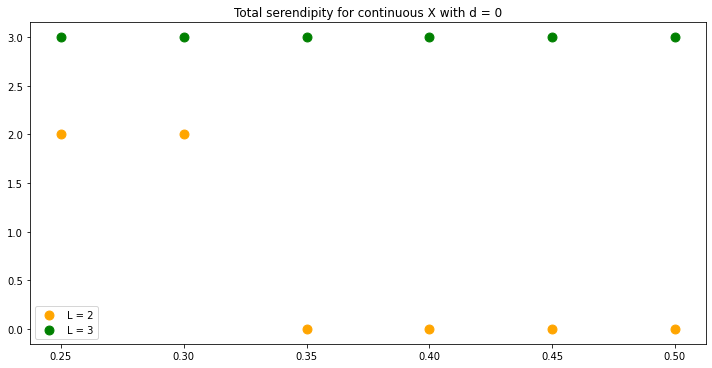

In [79]:
df1 = serendipity_results_cont_df.loc[serendipity_results_cont_df['L'] == 2]
df2 = serendipity_results_cont_df.loc[serendipity_results_cont_df['L'] == 3]

plt.figure(figsize=(10, 5))
plt.scatter(df1.theta, df1.max_score, c='orange', s=80, label='L = 2')
plt.scatter(df1.theta, df2.max_score, c='green', s=80, label='L = 3')
plt.legend()
plt.tight_layout()
plt.title('Total serendipity for continuous X with d = 0')
plt.show()

With disimilarity (d = 0)

Boolean

In [80]:
theta_results = []
recommendations_results = []
serendipity_results_wd_boolean = []
max_score_boolean_wd = []

In [81]:
for theta in theta_values:
    for recommendations in recommendations_values:
        theta_results.append(theta)
        recommendations_results.append(recommendations)
        score, matrix, recommendations_pairs = serendipity_recommendation_solver(theta, recommendations, 0, 1)
        total_serendipity = 0
        max_score_boolean_wd.append(score)
        if len(recommendations_pairs) > 0:
            for u in recommendations_pairs['userId'].unique():
                for m in recommendations_pairs['movieId'].unique():
                    total_serendipity += predicted[(similarities_user_movies[(u,m)], rated_movies_popularity[m])]
        serendipity_results_wd_boolean.append(total_serendipity)

    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution
    containing a solution


In [82]:
serendipity_results_wd_boolean

[153.0, 85.0, 66.0, 75.0, 90.0, 138.0, 148.0, 73.0, 127.0, 171.0, 150.0, 129.0]

In [83]:
max_score_boolean_wd

[4.0,
 9.0,
 4.0,
 9.0,
 3.962222222222222,
 9.0,
 4.0,
 9.0,
 3.6603174603174597,
 9.0,
 4.0,
 8.99047619047619]

In [97]:
serendipity_results_binary_wd_df = pd.DataFrame(
            {'theta': theta_results,
             'serendipity_indexes': serendipity_results_wd_boolean,
             'L': recommendations_results,
             'max_score': max_score_boolean_wd
            })

In [98]:
serendipity_results_binary_wd_df

,theta,serendipity_indexes,L,max_score
0,0.25,153.0,2,4.000000
1,0.25,85.0,3,9.000000
2,0.30,66.0,2,4.000000
3,0.30,75.0,3,9.000000
4,0.35,90.0,2,3.962222
5,0.35,138.0,3,9.000000
6,0.40,148.0,2,4.000000
7,0.40,73.0,3,9.000000
8,0.45,127.0,2,3.660317
9,0.45,171.0,3,9.000000


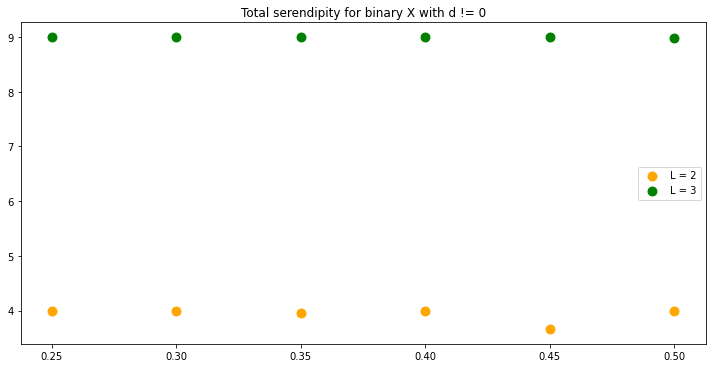

In [86]:
df1 = serendipity_results_binary_wd_df.loc[serendipity_results_binary_wd_df['L'] == 2]
df2 = serendipity_results_binary_wd_df.loc[serendipity_results_binary_wd_df['L'] == 3]

plt.figure(figsize=(10, 5))
plt.scatter(df1.theta, df1.max_score, c='orange', s=80, label='L = 2')
plt.scatter(df1.theta, df2.max_score, c='green', s=80, label='L = 3')
plt.legend()
plt.tight_layout()
plt.title('Total serendipity for binary X with d != 0')
plt.show()

Continuous

In [87]:
theta_results = []
recommendations_results = []
serendipity_results_wd_cont = []
max_score_cont_wd = []

In [88]:
for theta in theta_values:
    for recommendations in recommendations_values:
        theta_results.append(theta)
        recommendations_results.append(recommendations)
        score, matrix, recommendations_pairs = serendipity_recommendation_solver(theta, recommendations, 1, 1)
        total_serendipity = 0
        max_score_cont_wd.append(score)
        if len(recommendations_pairs) > 0:
            for u in recommendations_pairs['userId'].unique():
                for m in recommendations_pairs['movieId'].unique():
                    total_serendipity += predicted[(similarities_user_movies[(u,m)], rated_movies_popularity[m])]
        serendipity_results_wd_cont.append(total_serendipity)

In [89]:
serendipity_results_wd_cont

[29.0, 65.0, 29.0, 65.0, 29.0, 65.0, 29.0, 65.0, 27.0, 65.0, 27.0, 65.0]

In [90]:
max_score_cont_wd

[5.682489466520519,
 11.28560204716414,
 5.682437462002965,
 11.28560204711506,
 5.6822719614962205,
 11.285601709268118,
 5.681990242132542,
 11.28560170958828,
 5.681572962605425,
 11.285602047157582,
 5.681007992641692,
 11.285602046793185]

In [95]:
serendipity_results_cont_wd_df = pd.DataFrame(
            {'theta': theta_results,
             'serendipity_indexes': serendipity_results_wd_cont,
             'L': recommendations_results,
             'max_score': max_score_cont_wd
            })

In [96]:
serendipity_results_cont_wd_df

,theta,serendipity_indexes,L,max_score
0,0.25,29.0,2,5.682489
1,0.25,65.0,3,11.285602
2,0.30,29.0,2,5.682437
3,0.30,65.0,3,11.285602
4,0.35,29.0,2,5.682272
5,0.35,65.0,3,11.285602
6,0.40,29.0,2,5.681990
7,0.40,65.0,3,11.285602
8,0.45,27.0,2,5.681573
9,0.45,65.0,3,11.285602


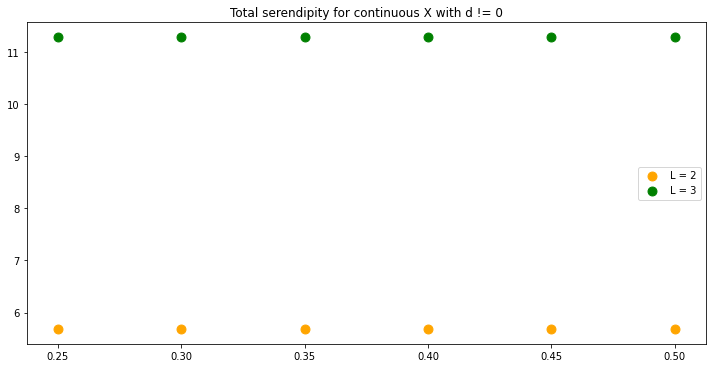

In [94]:
df1 = serendipity_results_cont_wd_df.loc[serendipity_results_cont_wd_df['L'] == 2]
df2 = serendipity_results_cont_wd_df.loc[serendipity_results_cont_wd_df['L'] == 3]

plt.figure(figsize=(10, 5))
plt.scatter(df1.theta, df1.max_score, c='orange', s=80, label='L = 2')
plt.scatter(df1.theta, df2.max_score, c='green', s=80, label='L = 3')
plt.legend()
plt.tight_layout()
plt.title('Total serendipity for continuous X with d != 0')
plt.show()